# Project: Annual Water Usage in Baltimore
Zaman serisi tahmini bir süreçtir ve iyi tahminler almanın tek yolu bu süreci uygulamaktır. Bu yazıda, Python ile Baltimore'da yıllık su kullanımının nasıl tahmin edileceğini keşfedeceksiniz. Bu eğitimde çalışmak, kendi zaman serisi tahmin sorunlarınız üzerinde çalışmak için adımlar ve araçlar için bir çerçeve sağlayacaktır.

Bu derste, uçtan uca, veri kümesini indirmekten ve sorunu tanımlamaktan nihai bir modeli eğitmeye ve tahminler yapmaya kadar bir zaman serisi tahmini projesi üzerinde çalışacağız. Bu proje kapsamlı değildir, ancak problemi sistematik olarak tahmin eden bir zaman serisi tahminiyle nasıl hızlı bir şekilde iyi sonuçlar alabileceğinizi gösterir. Bu projenin üzerinde çalışacağımız adımlar aşağıdaki gibidir.
1. Problem Description. 
2. Test Harness.
3. Persistence.
4. Data Analysis.
5. ARIMA Models.
6. Model Validation.

## Problem Description
Sorun yıllık su kullanımını tahmin etmektir. Veri kümesi Baltimore'da yıllık su kullanımını 1885'den 1963'e veya 79 yıllık verilerden sağlıyor. Değerler kişi başına günlük litre birimindedir ve 79 gözlem vardır.

## Test Harness
Verileri araştırmak ve aday modelleri değerlendirmek için bir test bandı geliştirmeliyiz. Bu iki adımdan oluşur:
* Defining a Validation Dataset.
* Developing a Method for Model Evaluation.


## Validation Dataset

Veri kümesi güncel değil. Bu, modeli doğrulamak için güncellenmiş verileri kolayca toplayamayacağımız anlamına gelir. Bu nedenle, 1953 gibi davranacağız ve analiz ve model seçiminden son 10 yıllık verileri saklayacağız. Bu son on veri, nihai modeli doğrulamak için kullanılacaktır.

In [13]:
# separate out a validation dataset
from pandas import read_csv
series = read_csv('water.csv',sep=";", header=0, index_col=0, parse_dates=True, squeeze=True)
series = series[0:79]
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


In [14]:
series

Year
1885-01-01    356.0
1886-01-01    386.0
1887-01-01    397.0
1888-01-01    397.0
1889-01-01    413.0
              ...  
1959-01-01    594.0
1960-01-01    587.0
1961-01-01    587.0
1962-01-01    625.0
1963-01-01    613.0
Name: Water, Length: 79, dtype: float64

## Persistence
The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared. The baseline prediction for time series forecasting is called the naive forecast, or persistence.

In [15]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

## Data Analysis
Tahmin sorununun yapısı hakkında hızlı bir şekilde daha fazla bilgi edinmek için özet istatistikleri ve verilerin grafiklerini kullanabiliriz. Bu bölümde, verilere dört açıdan bakacağız:
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.



## Summary Statistics

In [16]:
# summary statistics of time series
from pandas import read_csv
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
print(series.describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64


Some observations from these statistics include:
* Gözlem sayısı (sayım) beklentilerimize uyuyor, yani verileri doğru şekilde ele alıyoruz.
* Ortalama yaklaşık 500, bu serideki seviyemizi düşünebiliriz.


## Line Plot

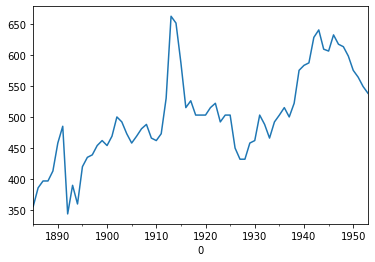

In [17]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
series.plot()
pyplot.show()

Some observations from the plot include:
* Zamanla su kullanımında artış trendi görülmektedir.
* Bazı büyük dalgalanmalar olmasına rağmen, belirgin bir aykırı değer görülmemektedir.
* Serinin son yıllarında düşüş trendi var.




Trend bileşenini açıkça modellemenin ve kaldırmanın bazı faydaları olabilir. Ayrıca, seriyi sabit hale getirmek için bir veya iki seviye arasındaki farkı kullanarak da keşfedebilirsiniz.

## Density Plot
Gözlem yoğunluğunun grafiklerini gözden geçirmek, verilerin yapısı hakkında daha fazla bilgi sağlayabilir. Aşağıdaki örnek, herhangi bir zamansal yapı olmaksızın gözlemlerin bir histogramını ve yoğunluk grafiğini oluşturmaktadır.


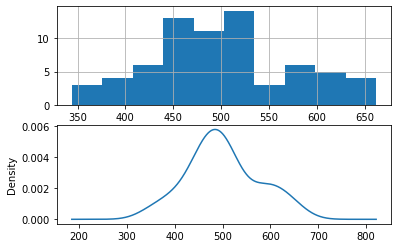

In [18]:
# density plots of time series
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

Some observations from the plots include:
* The distribution is not Gaussian, but is pretty close.
* The distribution has a long right tail and may suggest an exponential distribution or a double Gaussian.


Bu, modellemeden önce verilerin bazı güç dönüşümlerini keşfetmeye değer olabileceğini düşündürmektedir.

## Box and Whisker Plots
Yıllık verileri on yıla göre gruplandırabilir ve her on yıl için gözlemlerin yayılması ve bunun nasıl değişebileceği hakkında bir fikir edinebiliriz. Biraz eğilim görmeyi bekliyoruz (artan ortalama veya medyan), ancak dağılımın geri kalanının nasıl değiştiğini görmek ilginç olabilir. Aşağıdaki örnek, gözlemleri on yıla göre gruplandırır ve her on yıllık gözlem için bir kutu ve bıyık grafiği oluşturur. Son on yıl sadece 9 yıl içerir ve diğer on yıllarla yararlı bir karşılaştırma olmayabilir. Bu nedenle sadece 1885 ve 1944 arasındaki veriler çizildi.

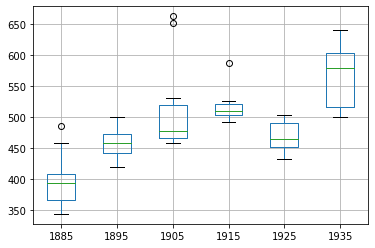

In [19]:
# boxplots of time series
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
groups = series.groupby(Grouper(freq='10YS'))
decades = DataFrame()
for name, group in groups:
    if len(group.values) is 10:
        decades[name.year] = group.values
decades.boxplot()
pyplot.show()

Some observations from reviewing the plot include:
* Her yıl için ortanca değerler (kırmızı çizgi) doğrusal olmayabilecek bir artış eğilimi gösterebilir.
* Verilerin yayılması veya orta% 50'si (mavi kutular) bazı değişkenlikler gösterir.
* Birkaç on yıl içinde belki aykırı değerler vardır (kutunun ve bıyıkların dışından geçer).
* Son on yılın ikinci yarısı, belki de birinci dünya savaşıyla ilişkili olarak daha düşük bir ortalama tüketime sahip gibi görünüyor.

Verilerin bu yıllık görünümü ilginç bir yoldur ve daha yakından takip edilebilir.
on yıldan on yıla kadar özet istatistikler ve özet istatistiklerde değişiklikler.

## ARIMA Models
### Manually Configured ARIMA
ARIMA (p, d, q) modeli üç parametre gerektirir ve geleneksel olarak manuel olarak yapılandırılır. Zaman serisi verilerinin analizi, sabit bir zaman serisi ile çalıştığımızı varsayar. Zaman serisi muhtemelen durağan değildir. İlk önce serileri farklılaştırarak ve sonucun sabit olduğunu doğrulamak için istatistiksel bir test kullanarak durağan hale getirebiliriz. Aşağıdaki örnek, serinin sabit bir sürümünü oluşturur ve bunu stationary.csv dosyasına kaydeder.

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


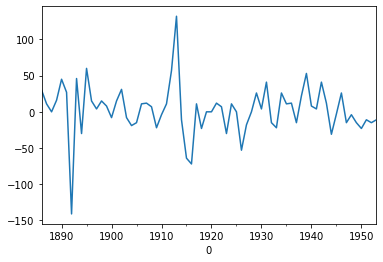

In [20]:
# create and summarize a stationary version of the time series
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
# create a differenced series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X) 
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv', header=False)

Sıfır hipotezinin reddedilmesi, işlemin birim kökü olmadığı ve zaman serisinin hareketsiz olduğu veya zamana bağlı bir yapıya sahip olmadığı anlamına gelir.

Bu, en az bir fark seviyesinin gerekli olduğunu göstermektedir. ARIMA modelimizdeki d parametresi en az 1 olmalıdır. Farklı verilerin bir grafiği de oluşturulur. Bunun gerçekten artan trendi ortadan kaldırdığını gösteriyor.

Bir sonraki ilk adım sırasıyla Otomatik Regresyon (AR) ve Hareketli Ortalama (MA) parametreleri, p ve q için gecikme değerlerini seçmektir. Bunu, Otokorelasyon Fonksiyonu (ACF) ve Kısmi Otokorelasyon Fonksiyonu (PACF) grafiklerini inceleyerek yapabiliriz

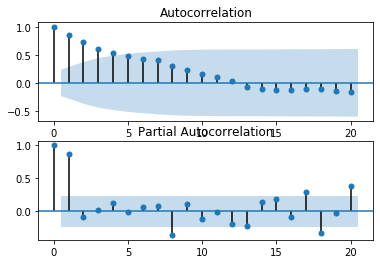

In [21]:
# ACF and PACF plots of the time series
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=20, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=20, ax=pyplot.gca())
pyplot.show()

* The ACF shows significant lags to 4 time steps.
* The PACF shows significant lags to 1 time step.
* A good starting point for the p is 4 and q is 1.

Bu hızlı analiz, ham veriler üzerindeki bir ARIMA'nın (4,1,1) iyi bir başlangıç ​​noktası olabileceğini düşündürmektedir. Tüm manuel ARIMA örneği aşağıda listelenmiştir.

In [22]:
# evaluate a manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=548.319, Expected=503.000
>Predicted=545.085, Expected=503.000
>Predicted=546.061, Expected=515.000
>Predicted=550.660, Expected=522.000
>Predicted=552.011, Expected=492.000
>Predicted=519.221, Expected=503.000
>Predicted=527.953, Expected=503.000
>Predicted=534.026, Expected=450.000
>Predicted=474.119, Expected=432.000
>Predicted=456.458, Expected=432.000
>Predicted=465.408, Expected=458.000
>Predicted=481.425, Expected=462.000
>Predicted=476.155, Expected=503.000
>Predicted=511.083, Expected=488.000
>Predicted=497.183, Expected=466.000
>Predicted=460.301, Expected=492.000
>Predicted=506.310, Expected=503.000
>Predicted=515.928, Expected=515.000
>Predicted=516.368, Expected=500.000
>Predicted=504.364, Expected=522.000
>Predicted=525.885, Expected=575.000
>Predicted=579.358, Expected=583.000
>Predicted=575.313, Expected=587.000
>Predicted=573.357, Expected=628.000
>Predicted=622.135, Expected=640.000
>Predicted=632.300, Expected=609.000
>Predicted=595.782, Expected=606.000
>

## Grid Search ARIMA Hyperparameters
* p: 0 to 4. 􏰀 
* d: 0 to 2. 􏰀 
* q: 0 to 4.

In [25]:
# grid search ARIMA parameters for a time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0) 
        yhat = model_fit.forecast()[0] 
        predictions.append(yhat) 
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 1) RMSE=282.658
ARIMA(0, 0, 2) RMSE=160.230
ARIMA(0, 0, 3) RMSE=97.012
ARIMA(0, 0, 4) RMSE=77.295
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(2, 1, 0) RMSE=21.733
Best ARIMA(2, 1, 0) RMSE=21.733


We will select this ARIMA(2,1,0) model going forward.

## Review Residual Errors
Bir modelin iyi bir son kontrolü, kalan tahmin hatalarını gözden geçirmektir. İdeal olarak, artık hataların dağılımı sıfır ortalamaya sahip bir Gauss olmalıdır. ARIMA (2,1,0) modelindeki artık hataları araştırmak için özet istatistikleri ve grafikleri kullanarak bunu kontrol edebiliriz. 

               0
count  35.000000
mean    1.081624
std    22.022566
min   -52.103812
25%   -16.202281
50%    -0.459803
75%    12.085091
max    51.284337


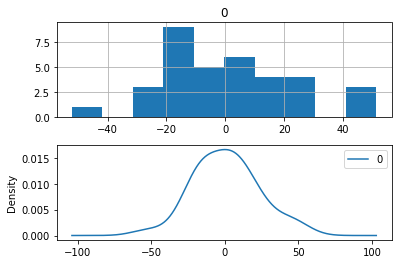

In [26]:
# summarize residual errors for an ARIMA model
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0)) 
    model_fit = model.fit(trend='nc', disp=0) 
    yhat = model_fit.forecast()[0] 
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211) 
residuals.hist(ax=pyplot.gca()) 
pyplot.subplot(212) 
residuals.plot(kind='kde', ax=pyplot.gca()) 
pyplot.show()

Bu bilgiyi, ortalama kalan hatayı ekleyerek tahminleri saptamak için kullanabiliriz
yapılan her tahmine 1.081624. Aşağıdaki örnek bu sapma düzeltmesini gerçekleştirir.

RMSE: 21.706
                  0
count  3.500000e+01
mean   3.734804e-07
std    2.202257e+01
min   -5.318544e+01
25%   -1.728390e+01
50%   -1.541427e+00
75%    1.100347e+01
max    5.020271e+01


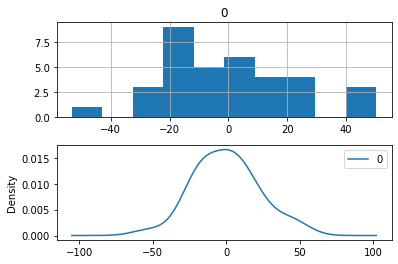

In [27]:
# summarize residual errors from bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0)) 
    model_fit = model.fit(trend='nc', disp=0) 
    yhat = bias + float(model_fit.forecast()[0]) 
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))] 
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211) 
residuals.hist(ax=pyplot.gca()) 
pyplot.subplot(212) 
residuals.plot(kind='kde', ax=pyplot.gca()) 
pyplot.show()

## Model Validation
* Finalize Model: Train and save the final model.
* 􏰀Make Prediction: Load the finalized model and make a prediction. 􏰀 
* Validate Model: Load and validate the final model.

## Finalize Model


In [28]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual bias = 1.081624
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

## Make Prediction

In [31]:
# load finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults 
import numpy
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0]) 
print('Predicted: %.3f' % yhat)

Predicted: 540.013


## Validate Model

>Predicted=540.013, Expected=568.000
>Predicted=571.589, Expected=575.000
>Predicted=573.289, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.063, Expected=602.000
>Predicted=603.022, Expected=594.000
>Predicted=593.178, Expected=587.000
>Predicted=588.558, Expected=587.000
>Predicted=588.797, Expected=625.000
>Predicted=627.941, Expected=613.000
RMSE: 16.532


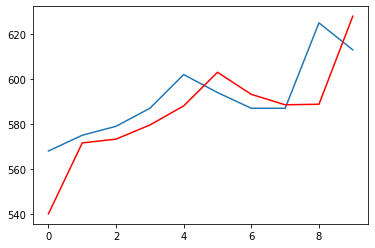

In [34]:
# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl') 
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0]) 
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0]) 
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions)) 
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red') 
pyplot.show()


Doğrulama veri kümesine kıyasla tahminlerin bir grafiği de verilmiştir. Tahmin, kalıcılık tahmini özelliklerine sahiptir. Bu, bu zaman serisinin belirgin bir eğilimi olmasına rağmen, hala oldukça zor bir sorun olduğunu göstermektedir.